# Photon Signal Rate Plots

This notebook outputs the reach plots in $\varepsilon - m_A$ space for IceCube.

Upon running this notebook the first time, run each cell sequentially. If however, you have started a calculation and now wish to continue where you left off, begin at the "External File Interpolations" cell and continue onward.

## Import Notebook as module

In [1]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
    
sys.meta_path.append(NotebookFinder())

print ('Complete')

Complete


In [2]:
from MasterFunctions_SignalRates import *
from MasterFunctions_Graphing import*

print ('All Notebooks Imported')

importing Jupyter notebook from MasterFunctions_SignalRates.ipynb
importing Jupyter notebook from MasterFunctions_Capture.ipynb
importing Jupyter notebook from MasterFunctions_ModelData.ipynb
------ MasterFunctions_ModelData Imported ------
------ MasterFunctions_Capture Imported ------
importing Jupyter notebook from MasterFunctions_Annihilation.ipynb
------ MasterFunctions_Annihilation Imported ------
------ MasterFunctions_SignalRates Imported ------
importing Jupyter notebook from MasterFunctions_Graphing.ipynb
------ MasterFunctions_Graphing Loaded ------
All Notebooks Imported


# Signal Rate


Recall the solution to the differential equation:
\begin{equation}
\frac{dN_X}{dt} = C_{cap} - N_X^2 C_{ann}
\end{equation}

is given by:

\begin{equation}
\Gamma_{ann} = \frac{1}{2} C_{cap}\tanh^2 \left( \frac{\tau_{\oplus}}{\tau} \right)
\end{equation}

more stuff about the signal rate

-------------

# Generate the Signal Data File

## Recipie

The recipie for generating the Signal File is:

1). Read in and interpolate a Sommerfeld file and Branching Ratio file
 
2). Initialize a template dataframe to hold the calculated signal rate data

3). Write that dataframe to an external .csv file (signalData.csv)

4). Append values from the Sommerfeld and Branching Ratio file to signalData.csv

5). Loop through signalData.csv, calculate $C_{Cap}$, $C_{Ann}$, $\Gamma_{Ann}$, and $N_{Sig}$, append them to signalData.csv

Step five can be quite lengthy depending on the desired resolution of the data points. Typically, one would begin these calculations and be forced to wait until they are completed in their entirety; perhaps unable to shut down their machine for hours at a time. The cell "Signal File Calculations" however can be interrupted at any time, and resumed later. This allows the user to run the calculation in multiple stages instead of dedicating a large chunk of time and running the calculation all at once. 
The calculation can be stopped by interrupting the Jupyter Kernel. Be sure to run the "Manual Overwrite" cell just to be sure that the calculations are saved.

## Initialize External Signal File

### Define the Resolution of the Reach (Signal) Plot

These cells create the "grid" of data points for which $N_{\text{sig} }$ will be calculated.

This cell initializes the resolution of the interpolations for the Sommerfeld enhancement and the reach plot. The variable $\texttt{num}$ defines the resolution of the grid, so if $\texttt{num} = 50$, the reach plot will have a $50 \times 50$ resolution for a total of 2500 calculations. The suggested resolution is 

    num = 200
    
A way to understand what this number does: "The cleaner your Sommerfeld interpolation, the cleaner your reach plots will be." Making this number larger will increase the resolution of the interpolation, cleaning up the plots, but it will take longer to calculate. 

A good rule of thumb: Your reach plot resolution will be determined by the resolution of the Sommerfeld Interpolation

In [3]:
# num = 200
num = 200

print ('Complete')

Complete


## External File Interpolations

The following cells read in and create interpolations of the:

1). Sommerfeld Enhancement

2). Branching ratio


The file names for both these files will be written to the signalData.csv file. The reasoning behind this is continuity of the calculation. If you run this notebook from top to bottom, you can calculate everything in one go. However, if you interrup the main calculation cell and restart your computer, all of the vairables we have loaded into Jupyter memroy get wiped. Writing these file names into the signalData.csv file means that to resume the calculation, you only need to run the main calculation cell as opposed to loading variables into Jupyter memory before starting the main calculation

### Sommerfeld Data Interpolation

This interpolation only serves to give you an idea of the resolution of the reach plot. We will read this in and interpolate it again later in the actual calulation. 

Sommerfeld File: 100GeVSommerfeld.csv
Sommerfeld interpolation complete
Complete


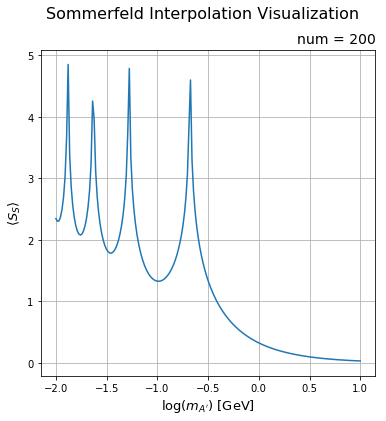

In [4]:
####################################
# Define Sommerfeld and Signal Files
####################################
SommFileName = input('Sommerfeld File: ')
SommFile = pd.read_csv(photonSommerfeldPath(SommFileName))

####################################
# Interpolate Sommerfeld data
####################################
mAData = SommFile['mA[GeV]']
SommData = SommFile['ThermAvgSommerfeld']
SommInterp = interpolate.interp1d(mAData,SommData)

print ('Sommerfeld interpolation complete')

####################################

####################################
m_XSommerfeld = SommFile.loc[0,'mX[GeV]']
kappa0Sommerfeld = SommFile.loc[0,'Kappa0']


vect1 = []
vect2 = []
for ma in np.logspace(-2,1, num, base = 10):
    vect1.append(ma)
    vect2.append(SommInterp(ma))

    
fig = plt.figure(figsize = (6,6))
plt.plot(np.log10(vect1),np.log10(vect2))
plt.xlabel(r"$\log(m_{A'})$ [GeV]", fontsize = 13)
plt.ylabel(r"$\langle S_S \rangle$", fontsize = 13)
plt.suptitle('Sommerfeld Interpolation Visualization', fontsize = 16)
plt.title('num = {0}'.format(num), fontsize = 14, loc = 'right')
plt.grid()

print ('Complete')

### Branching Ratio Interpolation

In this cell, we read in a .csv file containing discrete branching ratio data points obtained from WebPlotDigitizer and interpolate them into a continuous funciton named $\texttt{branchRatioInterp}$.

By decault, this cell reads in the branching ratio for $\gamma \rightarrow e^+e^-$. To change this, un-comment the first line and comment out the second line.

Complete


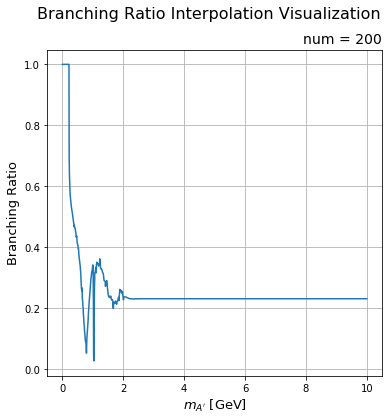

In [5]:
# branchFileName = input('Branching File: ')
branchFileName = 'brtoe.csv'

BranchData = pd.read_csv(photonBranchPath(branchFileName))

xListBranch = BranchData['mA[GeV]']
yListBranch = BranchData['BR']

branchRatioInterp = interpolate.interp1d(xListBranch,yListBranch)


fig = plt.figure(figsize = (6,6))
plt.plot(xListBranch,yListBranch)
plt.xlabel(r"$m_{A'}$ [GeV]", fontsize = 13)
plt.ylabel(r"Branching Ratio", fontsize = 13)
plt.suptitle('Branching Ratio Interpolation Visualization', fontsize = 16)
plt.title('num = {0}'.format(num), fontsize = 14, loc = 'right')
plt.grid()

print ('Complete')

## Initialize Signal Data File

### Initialize Dataframe

This cell:

1) Initializes the signal data frame

2) Appends the $\varepsilon$ and $m_{A'}$ data points based on the resolution dictated by the variable $\texttt{num}$

3) Appends the column headers to the data frame

In [6]:
#########################################
# Define parameter space Ranges
#########################################
# Logarithmic Spacing because we plot this in log-log space
# 0.01 GeV < mA < 10 GeV
# 10^-11 < Epsilon < 10^-5
mALogRange = np.logspace(-2, 1, num, base = 10)
epsilonLogRange = np.logspace(-11, -5, num, base = 10)

#########################################
# Initialize Master Arrays
#########################################
masterSignalArray = []

#########################################
# Populate the Master Arrays with the column headers and 'None' Cells
#########################################
counter = 0
for mATemp in mALogRange:
    for epsilonTemp in epsilonLogRange:
        masterSignalArray.append([counter, ' ', mATemp, epsilonTemp, \
                                  'None', 'None', 'None', 'None', \
                                  ' ', ' ',' ', ' '])
        counter +=1
#########################################
# Create a PANDAS DataFrame from the Master Arrays
#########################################
masterSignalDataframe = pd.DataFrame(data = masterSignalArray, \
    columns=['Counter', 'mX[GeV]', 'mA[GeV]', 'Epsilon',\
             'Capture[s-1]', 'Annihilation[s-1]', 'GammaAnn[s-1]', 'IceCubeSignal', \
             'SommerfeldFile', 'BranchingRatioFile','Resolution','Kappa0[GeV5]'])

# filename = input('Signal Rate Filename: ')
# writeFile = photonSignalDataPath(filename)
# masterSignalDataframe.to_csv(writeFile, index=False)

print ('Complete')

Complete


## Write to External .csv File

This cell writes the signal data frame to an external csv file.

In [7]:
SignalFile = input('Signal Rate filename: ')
writeFile = photonSignalDataPath_Incomplete(SignalFile)


#############################
# Double check that these values are correct
#############################
print ('--------------------')
print ('You are about to commit the following to {0}'.format(SignalFile))
print ('mX[GeV]             : {0}'.format(m_XSommerfeld))
print ('Kappa0[GeV5]        : {0}'.format(kappa0Sommerfeld))
print ('Sommerfeld File     : {0}'.format(SommFileName))
print ('Branching Ratio File: {0}'.format(branchFileName))
print ('Resolution          : {0}'.format(num))

print ()

yesNo = input ('Commit to .csv? (y/n)')
assert (yesNo == 'y' or yesNo == 'n'), 'Invalid input, must be "y" or "n."'

if (yesNo == 'y'):

    # Append a single value onto the Kappa0 Column
    kappa0Value = 'None'
    m_XValue = 'None'

    # print (branchFile)

    masterSignalDataframe.set_value(0, 'mX[GeV]', m_XSommerfeld)
    masterSignalDataframe.set_value(0, 'Kappa0[GeV5]' , kappa0Sommerfeld)
    masterSignalDataframe.set_value(0, 'SommerfeldFile', SommFileName)
    masterSignalDataframe.set_value(0, 'BranchingRatioFile', branchFileName)
    masterSignalDataframe.set_value(0, 'Resolution', num)

    masterSignalDataframe.to_csv(writeFile, index=False)
    
    print ('Commit Executed')
    
else:
    print ('Commit aborted')

print ('Complete')

Signal Rate filename: 100GeVSignal.csv
--------------------
You are about to commit the following to 100GeVSignal.csv
mX[GeV]             : 100.0
Kappa0[GeV5]        : 5.872636700277879e+27
Sommerfeld File     : 100GeVSommerfeld.csv
Branching Ratio File: brtoe.csv
Resolution          : 200

Commit to .csv? (y/n)y
Commit Executed
Complete


## Sanity Check

We expect that:

1). The "Counter" column should be $\texttt{num}^2$ elements long 

2). "Resolution" has the value for $\texttt{num}$ stored in it

3). The $m_X$ and Kappa0 value from the Sommerfeld file are appended to the Signal file

4). The Signal file has 12 columns labeled:
    
    Counter, mX[GeV], mA[GeV], Epsilon[s-1], Capture[s-1], Annihilation[s-1], GammaAnn[s-1],
    IceCubeSignal, SommerfeldFile, BranchingRatioFile, Kappa0[GeV5]
    
5). "SommerfeldFile" and "BranchingRatioFile" are actually what you want them to be

In [8]:
filename = input('Signal Rate filename: ')
writeFile = photonSignalDataPath_Incomplete(filename)

print (pd.read_csv(writeFile, sep = ','))
print ('Complete')

Signal Rate filename: 100GeVSignal.csv
       Counter mX[GeV]  mA[GeV]       Epsilon Capture[s-1] Annihilation[s-1]  \
0            0   100.0     0.01  1.000000e-11         None              None   
1            1             0.01  1.071891e-11         None              None   
2            2             0.01  1.148951e-11         None              None   
3            3             0.01  1.231551e-11         None              None   
4            4             0.01  1.320088e-11         None              None   
5            5             0.01  1.414991e-11         None              None   
6            6             0.01  1.516717e-11         None              None   
7            7             0.01  1.625756e-11         None              None   
8            8             0.01  1.742633e-11         None              None   
9            9             0.01  1.867914e-11         None              None   
10          10             0.01  2.002200e-11         None              None   
1

# Signal Calculations

Run these two cells onces you have a working signalData.csv file and you want to either start or resume calculations.

## SignalData.csv Calculations

This cell scans through all the lines of signalData.csv file and calculates:

1). Capture

2). Annihilation

3). GammaAnn

4). Signal

As mentioned previously, this cell may be stopped, by interrupting the kernel, at any time and resumed later.

In [9]:
signalFileName = input('Signal Rate File: ')
signalWriteFile = photonSignalDataPath_Incomplete(signalFileName)
signalDataIn = pd.read_csv(signalWriteFile, sep = ',')

#########################################
# Define loop range
#########################################
# Scan down 'Counter' column, start calculating at first non-calculated value

#########################################
# Parameters independent of data file:
#########################################
Filem_X = float(signalDataIn.loc[0, 'mX[GeV]'])
FileKappa0 = float(signalDataIn.loc[0, 'Kappa0[GeV5]'])
Alpha = 1./137
LiveTime = yr2s(10)


#########################################
# Sommerfeld Interpolation
#########################################
sommFileName = signalDataIn.loc[0,'SommerfeldFile']
sommDataIn = pd.read_csv(photonSommerfeldPath(sommFileName))
mAData1 = sommDataIn['mA[GeV]']
SommDataValues = sommDataIn['ThermAvgSommerfeld']
SommInterp = interpolate.interp1d(mAData1,SommDataValues)

#########################################
# Branching Ratio Interpolation
#########################################
branchFileName = signalDataIn.loc[0,'BranchingRatioFile']
branchDataIn = pd.read_csv(photonBranchPath(branchFileName))

mABranch = branchDataIn['mA[GeV]']
branchingDataValues = branchDataIn['BR']

branchRatioInterp = interpolate.interp1d(mABranch,branchingDataValues)


#########################################
# Begin the loop calculations
#########################################
loopRange = range(0,len(signalDataIn['Counter']))

print (signalFileName)
print ()
print ('--------------------')
finishedCounter = 0
index = 0
for index in loopRange:
    testValue = signalDataIn.loc[index, 'IceCubeSignal']
    
    if (testValue == 'None'):
        signalDataIn.to_csv(signalWriteFile, sep=',',index=False) 

        #########################################
        # Initialize loop-specific Quantities
        #########################################
        Filem_ATemp = float(signalDataIn.loc[index, 'mA[GeV]'])
        FileEpsilonTemp = float(signalDataIn.loc[index, 'Epsilon'])
        Alpha_X = alphaTherm(Filem_X, Filem_ATemp)
        Sommerfeld = SommInterp(Filem_ATemp)
        BranchingRatio = branchRatioInterp(Filem_ATemp)
        
        #########################################
        # Loop Calculations
        #########################################
        Capture = photonCCapQuick(Filem_X, Filem_ATemp, FileEpsilonTemp, Alpha_X, FileKappa0)
        SigmaVTree = photonSigmaVtree(Filem_X, Filem_ATemp, Alpha_X)
        Annihilation = CAnnCalc(Filem_X, SigmaVTree, thermAvgSomm = Sommerfeld)
        GammaAnn = gammaAnn(Capture, Annihilation)
        L = decayLength(Filem_X, Filem_ATemp, FileEpsilonTemp, BranchingRatio)
        EpsilonDecay = epsilonDecay(L)
        
        IceCubeSignal = iceCubeSignal(GammaAnn, EpsilonDecay, LiveTime)
        
        #########################################
        # Append Calculated Values to SignalFile.csv
        #########################################
        signalDataIn.set_value(index, 'Capture[s-1]', Capture)
        signalDataIn.set_value(index, 'Annihilation[s-1]', Annihilation)
        signalDataIn.set_value(index, 'GammaAnn[s-1]', GammaAnn)
        signalDataIn.set_value(index, 'IceCubeSignal', IceCubeSignal)
        
        
        #########################################
        # Overwrite SignalFile.csv
        #########################################
        signalDataIn.to_csv(signalWriteFile, sep=',',index=False) 
        finishedCounter += 1
        
        if (index % 20 == 0):
            print ('Calculations for index: {0} recorded'.format(index))
        
    elif (testValue != 'None'):
        finishedCounter += 1
    
    if (finishedCounter == len(signalDataIn['Counter'])):
        print ('--------------------')
        print ('All Calculations Complete')
        break
        
print ('Complete')

Signal Rate File: 100GeVSignal.csv
100GeVSignal.csv

--------------------
Calculations for index: 0 recorded
Calculations for index: 20 recorded
Calculations for index: 40 recorded
Calculations for index: 60 recorded
Calculations for index: 80 recorded
Calculations for index: 100 recorded
Calculations for index: 120 recorded
Calculations for index: 140 recorded
Calculations for index: 160 recorded
Calculations for index: 180 recorded
Calculations for index: 200 recorded
Calculations for index: 220 recorded
Calculations for index: 240 recorded
Calculations for index: 260 recorded
Calculations for index: 280 recorded
Calculations for index: 300 recorded
Calculations for index: 320 recorded
Calculations for index: 340 recorded
Calculations for index: 360 recorded
Calculations for index: 380 recorded
Calculations for index: 400 recorded
Calculations for index: 420 recorded
Calculations for index: 440 recorded
Calculations for index: 460 recorded
Calculations for index: 480 recorded
Calcula

Calculations for index: 4320 recorded
Calculations for index: 4340 recorded
Calculations for index: 4360 recorded
Calculations for index: 4380 recorded
Calculations for index: 4400 recorded
Calculations for index: 4420 recorded
Calculations for index: 4440 recorded
Calculations for index: 4460 recorded
Calculations for index: 4480 recorded
Calculations for index: 4500 recorded
Calculations for index: 4520 recorded
Calculations for index: 4540 recorded
Calculations for index: 4560 recorded
Calculations for index: 4580 recorded
Calculations for index: 4600 recorded
Calculations for index: 4620 recorded
Calculations for index: 4640 recorded
Calculations for index: 4660 recorded
Calculations for index: 4680 recorded
Calculations for index: 4700 recorded
Calculations for index: 4720 recorded
Calculations for index: 4740 recorded
Calculations for index: 4760 recorded
Calculations for index: 4780 recorded
Calculations for index: 4800 recorded
Calculations for index: 4820 recorded
Calculations

Calculations for index: 8640 recorded
Calculations for index: 8660 recorded
Calculations for index: 8680 recorded
Calculations for index: 8700 recorded
Calculations for index: 8720 recorded
Calculations for index: 8740 recorded
Calculations for index: 8760 recorded
Calculations for index: 8780 recorded
Calculations for index: 8800 recorded
Calculations for index: 8820 recorded
Calculations for index: 8840 recorded
Calculations for index: 8860 recorded
Calculations for index: 8880 recorded
Calculations for index: 8900 recorded
Calculations for index: 8920 recorded
Calculations for index: 8940 recorded
Calculations for index: 8960 recorded
Calculations for index: 8980 recorded
Calculations for index: 9000 recorded
Calculations for index: 9020 recorded
Calculations for index: 9040 recorded
Calculations for index: 9060 recorded
Calculations for index: 9080 recorded
Calculations for index: 9100 recorded
Calculations for index: 9120 recorded
Calculations for index: 9140 recorded
Calculations

KeyboardInterrupt: 

## Manual Overwrite

This cell is a manual overwrite of the signalData.csv file.

It is REQUIRED that you run this if you interrupt the calculation. Failure to do so could result in a loss of all your data.

In [10]:
signalDataIn.to_csv(signalWriteFile, sep=',',index=False) 

print ('Complete')

Complete


------------------------

# Signal Graphs

The general recipie is:

1). Read in a Signal Data file

2). Extract the plot information

3). Plot


## Read in External Signal File

In [20]:
GammaFile = input('Signal Rate filename: ')
readFile = photonSignalDataPath_Complete(GammaFile)
testRead = pd.read_csv(readFile) # This is here to ensure that the file exists

print ('Complete')

Signal Rate filename: 100GeVSignalTest.csv
Complete


## Define the plot region and extract plot data

We plot the Data under the column

    mA[GeV], Epsilon, IceCubeSignal

In [21]:
rawData = pd.read_csv(photonSignalDataPath_Complete(GammaFile))
Filem_X = float(rawData.loc[0,'mX[GeV]'])


#Pull out min / max values

xMin = min(rawData['mA[GeV]'])
xMax = max(rawData['mA[GeV]'])
yMin = min(rawData['Epsilon'])
yMax = max(rawData['Epsilon'])


# Define the dimension of the grid. 
# For an n x n grid, this will pull out the number "n"
# gridDim = len(np.unique(rawData['mA[GeV]']))
gridDim = int(rawData.loc[0,'Resolution'])



#########################################
# Create the n x n grid
#########################################
# Logarithmic Spacing
xLogRange = np.logspace(xMin, xMax, gridDim, base = 10)
yLogRange = np.logspace(yMin, yMax, gridDim, base = 10)

xLinRange = np.linspace(xMin, xMax, gridDim)
yLinRange = np.linspace(yMin, yMax, gridDim)

#########################################
# Read in and reshape the Contour data
#########################################
# This reads in contour data as a single column,
#     but we reshape it to a 2D, n x n array to fit the grid

z = [rawData['IceCubeSignal']]
SignalData = np.reshape(z, (len(xLinRange), len(yLinRange)))

print ('Complete')

Complete


## Plot the Signal Events

C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


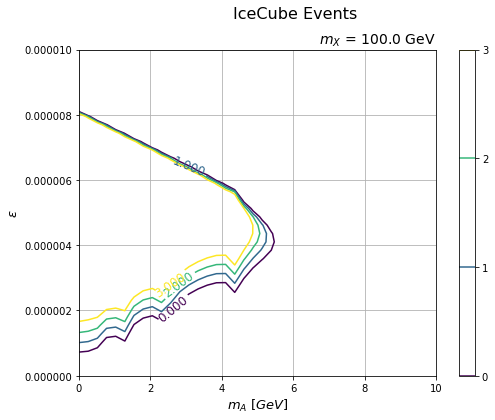

In [22]:
###############################
# Set the correct units for m_X
###############################
m_XUnit = 'None'
if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X * 10**-3
    m_XUnit = 'TeV'
    
    
###############################
# Define X,Y tickmarks
###############################
# xTicks = np.linspace(xMin, xMax, 10)
# yTicks = np.linspace(yMin, yMax, 10)
# xTicks = np.logspace((xMin), (xMax), 7, base = 10)
# yTicks = np.logspace(np.log10(yMin),np.log10(yMax),7, base = 10)
    
###############################
# Actual Plotting Stuff
###############################
fig0 = plt.figure(figsize = (8,6))
ax0 = fig0.add_subplot(111)
# ax0.set_xticks(xTicks)
# ax0.set_yticks(yTicks)

CP = plt.contour(np.log10(xLogRange), np.log10(yLogRange), \
                 np.log10(SignalData.transpose()),\
                 levels=[0,1,2,3],
                )


plt.xlabel(r'$m_A$ $[GeV]$', fontsize = 13)
plt.ylabel(r'$\varepsilon$', fontsize = 13)
plt.suptitle('IceCube Events', fontsize = 16)
plt.title(r'$m_X$ = {0} {1}'.format(m_XDisplay, m_XUnit), loc = 'right', fontsize = 14)
# plt.axis([xMin,xMax,yMin,yMax])
plt.clabel(CP, inline=1, fontsize=12)
plt.colorbar()
plt.grid()

### Save Figure

In [ ]:
figName = input('Filename: ')

fig0.savefig(photonSignalPlotPath(figName), dpi = 700, bbox_inches = 'tight')
print ('Complete')

In [ ]:
###############################
# Set the correct units for m_X
###############################
m_XUnit = 'None'
if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X * 10**-3
    m_XUnit = 'TeV'
    
    
###############################
# Define X,Y tickmarks
###############################
# xTicks = np.linspace(xMin, xMax, 10)
# yTicks = np.linspace(yMin, yMax, 10)
# xTicks = np.logspace((xMin), (xMax), 7, base = 10)
# yTicks = np.logspace(np.log10(yMin),np.log10(yMax),7, base = 10)
    
###############################
# Actual Plotting Stuff
###############################
fig0 = plt.figure(figsize = (8,6))
ax0 = fig0.add_subplot(111)
# ax0.set_xticks(xTicks)
# ax0.set_yticks(yTicks)

CP = plt.contour(np.log10(xLogRange), np.log10(yLogRange), \
                 np.log10(SignalData.transpose()),\
                 levels=[0,1,2,3,],
                )


plt.xlabel(r'$m_A$ $[GeV]$', fontsize = 13)
plt.ylabel(r'$\varepsilon$', fontsize = 13)
plt.suptitle('IceCube Events', fontsize = 14)
plt.title(r'$m_X$ = {0} {1}'.format(m_XDisplay, m_XUnit), loc = 'right', fontsize = 13)
# plt.axis([xMin,xMax,yMin,yMax])
plt.clabel(CP, inline=1, fontsize=12)
plt.colorbar(CP)
plt.grid()

## Sanity Checks

For the following parameters:

- $m_X = 1000$ GeV

- $m_A = 1.0$ GeV

- $\varepsilon = 10^{-8}$

we know for certain:
- $C_{Cap} \sim 1.09185621\times 10^8$

- $C_{Ann} \sim 1.66001111034\times 10^{-46}$ (with Sommerfeld)

- $\frac{\tau}{\tau_{\oplus}} \mathcal{O}(10^1 - 10^2)$

- $N_{sig} \sim \mathcal{O}(10^2 - 10^3)$

Un-comment the following cell to debug.

In [ ]:
# testm_X = 1000.
# testm_A = 1.0
# testEpsilon = 10**-8
# alpha_X = alphaTherm(testm_X, testm_A)
# LiveTime = yr2s(10)
# BranchingRatio = 1

# # # Capture Functions
# Kappa0 = kappa_0(testm_X, 1./137)
# Capture = CCapQuick(testm_X, testm_A, testEpsilon, alpha_X, Kappa0)

# # # Annihilation Functions
# Sommerfeld = thermAvgSommerfeld(testm_X, testm_A, alpha_X)
# Annihilation = CAnn(testm_X, testm_A, alpha_X, Sommerfeld)

# # # Equilibrium Time
# EQTime = tau(Capture, Annihilation)
# EQRatio = EQTime/tauCross

# # # Signal Rates
# GammaAnn = gammaAnnCalc(Capture, Annihilation)
# # DecayLength = decayLength2(testm_X, testm_A, testEpsilon, BranchingRatio)
# DecayLength = decayLengthJordan(testm_X, testm_A, testEpsilon, BranchingRatio)
# EpsilonDecay = epsilonDecay(DecayLength)
# Signal = iceCubeSignal(GammaAnn, EpsilonDecay, LiveTime)


# print ('Complete')

In [ ]:
# print ('Capture       : {0}'.format(Capture))
# print ('Annihilation  : {0}'.format(Annihilation))
# print ('Tau:          : {0}'.format(EQTime))
# print ('EQ Ratio      : {0}'.format(EQRatio))
# print ('GammaAnn      : {0}'.format(GammaAnn))
# print ('DecayLength   : {0}'.format(DecayLength))
# print ('RCross        : {0}'.format(RCross))
# print ('Epsilon Decay : {0}'.format(EpsilonDecay))
# print ('Signal        : {0}'.format(Signal))

# print ('Complete')